**Test Script For FRA333 HW3**
- Member
    - นายปวริศ อัศวกิจธนานนท์ 65340500037

In [288]:
import roboticstoolbox as rtb
import numpy as np
from math import pi
from spatialmath import *
from HW3_utils import *
from FRA333_HW3_6537 import *

### **Robot Modeling**
- define DH parameter of Robot

In [289]:
d1 = 0.0892
a2 = -0.425
T_3_e = SE3(-0.39243,-0.093,0.109) * SE3(-0.082,0,0) * SE3.RPY([0,-pi/2,0])
robot = rtb.DHRobot(
    [
        rtb.RevoluteMDH(d = d1 , offset=pi), # {1}
        rtb.RevoluteMDH(alpha=pi/2), # {2}
        rtb.RevoluteMDH(a=a2), # {3}
    ],tool = T_3_e, name="3R robot")
print(robot)

DHRobot: 3R robot, 3 joints (RRR), dynamics, modified DH parameters
┌────────┬───────┬────────────┬────────┐
│  aⱼ₋₁  │ ⍺ⱼ₋₁  │     θⱼ     │   dⱼ   │
├────────┼───────┼────────────┼────────┤
│    0.0 │  0.0° │  q1 + 180° │ 0.0892 │
│    0.0 │ 90.0° │         q2 │    0.0 │
│ -0.425 │  0.0° │         q3 │    0.0 │
└────────┴───────┴────────────┴────────┘

┌──────┬─────────────────────────────────────────────────┐
│ tool │ t = -0.47, -0.093, 0.11; rpy/xyz = 0°, -90°, 0° │
└──────┴─────────────────────────────────────────────────┘



- Home Position 

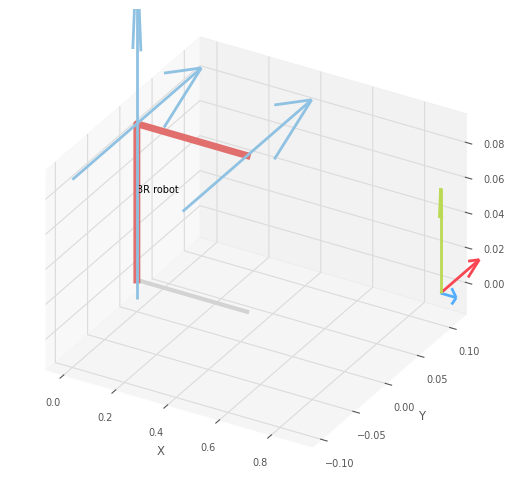

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, '3R robot')

<Figure size 640x480 with 0 Axes>

In [290]:
q = [0,0,0]
robot.plot(q)

### **Validation**

**Forward Kinematic test**

In [291]:
print("Pose from RTB-py")
print(robot.fkine(q))
print("___________________________________________\n\n")
print("Pose from HW3")
R,P,R_e,p_e = FKHW3(q)
print(f"Position is {p_e}")
print("Orinetation Matrix")
print(R_e)

Pose from RTB-py
   0         0         1         0.8994    
   1         0         0         0.109     
   0         1         0        -0.0038    
   0         0         0         1         

___________________________________________


Pose from HW3
Position is [ 0.89943  0.109   -0.0038 ]
Orinetation Matrix
[[ 6.1232343e-17  6.1232343e-17  1.0000000e+00]
 [ 1.0000000e+00 -1.2246469e-16 -6.1232343e-17]
 [ 1.2246469e-16  1.0000000e+00 -6.1232343e-17]]


**1. Jacobian Test**
- Jacobian matrix at end-effector frame relate to base frame (frame 0)

this function is random joint angles between (-pi , pi)

In [292]:
def JacobianTest(robot):
    q1,q2,q3 = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)
    q = [q1,q2,q3]                      #   Random Joint Angle
    print("Jacobian from RTB-py")
    print(robot.jacob0(q))
    print("___________________________________________\n")
    print("Jacobian from HW3")
    print(endEffectorJacobianHW3(q))

In [293]:
JacobianTest(robot)     # Random Joint Angle and compare result of Jacobian matrix 

Jacobian from RTB-py
[[ 6.33268241e-01 -7.26938107e-02 -3.14895262e-03]
 [-6.47786702e-01 -5.56590403e-02 -2.41103993e-03]
 [-3.72496718e-18 -8.99319340e-01 -4.83442960e-01]
 [ 1.48599967e-17  6.07930069e-01  6.07930069e-01]
 [ 3.03649309e-17 -7.93990574e-01 -7.93990574e-01]
 [ 1.00000000e+00  6.12323400e-17  6.12323400e-17]]
___________________________________________

Jacobian from HW3
[[ 6.33268241e-01 -7.26938087e-02 -3.14895253e-03]
 [-6.47786702e-01 -5.56590399e-02 -2.41103992e-03]
 [ 0.00000000e+00 -8.99319323e-01 -4.83442952e-01]
 [ 0.00000000e+00  6.07930064e-01  6.07930064e-01]
 [ 0.00000000e+00 -7.93990552e-01 -7.93990552e-01]
 [ 1.00000000e+00  6.12323426e-17  6.12323426e-17]]


**2. Singularity test**
- for RRR Robot Singularity


In [294]:
# Singularity Case
q = [0,-np.pi/2 - 0.1,0] # Define q that make robot be singularity
J_full = endEffectorJacobianHW3(q)  # Full Jacobian
J_reduce = J_full[0:3, 0:3]         # Reduced Jacobian for 3-DoF
rank = np.linalg.matrix_rank(J_reduce)
print(f"Jacobian HW3 Det :  {np.linalg.det(J_reduce)}")
print(f"Jacobian RTB Det :  {np.linalg.det(robot.jacob0(q)[:3,:])}")
print(f"is Singularity : {checkSingularityHW3(q)}")

Jacobian HW3 Det :  0.00010838614416579427
Jacobian RTB Det :  0.00010838614416579408
is Singularity : True


In [295]:
# Random Case
q = [np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)]
robot.jacob0(q)
J_full = endEffectorJacobianHW3(q)  # Full Jacobian
J_reduce = J_full[0:3, 0:3]         # Reduced Jacobian for 3-DoF
rank = np.linalg.matrix_rank(J_reduce)
print(f"Jacobian HW3 Det :  {np.linalg.det(J_reduce)}")
print(f"Jacobian RTB Det :  {np.linalg.det(robot.jacob0(q)[:3,:])}")
print(f"is Singularity : {checkSingularityHW3(q)}")

Jacobian HW3 Det :  -0.1370470952642881
Jacobian RTB Det :  -0.13704709755348732
is Singularity : False


- We can't prove with robot.manipulability or Manipulabity equation beacuse of it's calculate from 6 DoF(if we use RTB)
        - Robot is only 3 DoF that say we can't find manipulability with 6 DoF
- if we indice Jacobian matrix to 3x3 and use robot.manipulability we will get same result to |np.linalg.det(J_reduce)|

**3. Joint Effort test**

In [296]:
q = [0.1,-2.1,1.14]
w = [5,2,8,4,5,10]
m_e = w[:3] # moment
f_e = w[3:] # force
w_e = np.concatenate((f_e, m_e),axis = 0)   # Concatenate to Wrench vector
a = robot.pay(W= w_e , q = q,frame=1)       # Calculating Joint Effort from RTB-py
b = computeEffortHW3(q,w)                   # Calculating Joint Effort from HW3
print(f"Joint Effort RTB : {a}")
print(f"Joint Effort HW3 : {b}")

Joint Effort RTB : [-8.05677637 -4.67215404 -1.69785   ]
Joint Effort HW3 : [8.05677649 4.67215407 1.69785001]


Joint Effort RTB 
- Refers to the torque required by the manipulator to counteract the external force applied at the end-effector.

Joint Effort HW3 
- Refers to the torque generated by the external force acting on the manipulator.

random test case for Joint Effort test

In [297]:
def JointEffortTest(robot):
    q1,q2,q3 = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)
    q = [q1,q2,q3]
    w = np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi),np.random.uniform(-np.pi, np.pi)

    m_e = w[:3] # moment
    f_e = w[3:] # force
    w_e = np.concatenate((f_e, m_e),axis = 0)   # Concatenate to Wrench vector
    a = robot.pay(W= w_e , q = q,frame=1)       # Calculating Joint Effort from RTB-py
    b = computeEffortHW3(q,w)                   # Calculating Joint Effort from HW3
    print(f"Joint Effort RTB : {a}")
    print(f"Joint Effort HW3 : {b}")

In [298]:
JointEffortTest(robot)

Joint Effort RTB : [2.79711153 3.28119167 2.06573256]
Joint Effort HW3 : [-2.79711162 -3.28119182 -2.06573266]
